In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 9.3 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.1 MB 8.0 MB/s eta 0:00:01
   ---------------------- ----------------- 4.5/8.1 MB 7.3 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 7.0 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 6.7 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.2 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ------------ --------------------------- 2.1/7.0 MB 10.7 MB/s eta

In [4]:
# Download historical AAPL stock prices
df = yf.download("AAPL", start="2015-01-01", end="2025-06-30", auto_adjust=True)

# We only use the closing price
prices = df[["Close"]]

# Scale the data to range [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(prices)


[*********************100%***********************]  1 of 1 completed


In [5]:
def make_sequences(series, look_back=20):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back])
    return np.array(X), np.array(y)

LOOK_BACK = 20  # You can try 30 or 50 later
X, y = make_sequences(scaled, LOOK_BACK)

# Check the shapes
print("X shape:", X.shape)  # should be (samples, 20, 1)
print("y shape:", y.shape)


X shape: (2617, 20, 1)
y shape: (2617, 1)


In [6]:
# 80% training, 20% testing (chronological split)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [7]:
model = Sequential([
    LSTM(64, input_shape=(LOOK_BACK, 1)),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)



C:\Users\Admin\miniconda3\envs\stock-lstm\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0236 - val_loss: 0.0010
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9453e-04 - val_loss: 7.7999e-04
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7358e-04 - val_loss: 6.5966e-04
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4088e-04 - val_loss: 6.0235e-04
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1173e-04 - val_loss: 5.9353e-04
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9130e-04 - val_loss: 5.7605e-04
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1500e-04 - val_loss: 5.4496e-04
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0303e-04 - val_loss: 7.2525e-04
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9141e-04 - val_loss: 5.0730e-04
Epoch 10/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6199e-04 - val_loss: 4.9024e-04
Epoch 11/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8093e-04 - val_loss: 5

In [8]:
# Predict scaled values
pred_scaled = model.predict(X_test).flatten()

# Inverse transform both predictions and actual values
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


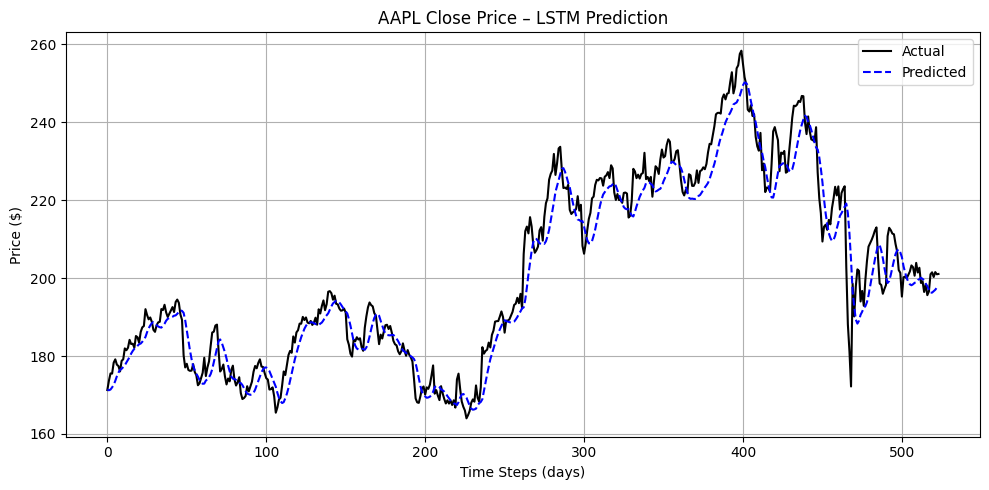

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actual, label="Actual", color='black')
plt.plot(pred, label="Predicted", linestyle='--', color='blue')
plt.title("AAPL Close Price – LSTM Prediction")
plt.xlabel("Time Steps (days)")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE :", mean_absolute_error(actual, pred))
print("RMSE:", np.sqrt(mean_squared_error(actual, pred)))
print("R²  :", r2_score(actual, pred))


MAE : 4.590249156223906
RMSE: 6.088709059635362
R²  : 0.935283025835928
